In [1]:
import glob
from tqdm import tqdm
import librosa
import numpy as np
import pandas
import matplotlib.pyplot as plt
import seaborn

import struct
import numpy as np
import webrtcvad

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
# Properties

fs = 16000     # LibriSpeech sampling frequency [Hz]
dur = 1        # Audio duration [s]
win_dur = 0.02
max_attempts = 20

In [3]:
# Data picking

librispeech_path = 'D:\\Università\\Tesi\\Datasets\\LibriSpeech\\dev-clean\\'

txt_path = 'D:\\Università\\Tesi\\Datasets\\LibriSpeech\\SPEAKERS2.TXT'
data_info = pandas.read_fwf(txt_path, delimiter='\t|')

data_subset_info = data_info.loc[data_info[' SUBSET           '] == ' dev-clean        ']
male_subset = data_subset_info.loc[data_subset_info['SEX'] == ' M ']
female_subset = data_subset_info.loc[data_subset_info['SEX'] == ' F ']

male_ID = pandas.Series.tolist(male_subset['ID   '])
female_ID = pandas.Series.tolist(female_subset['ID   '])
data_subset_info.head()

,ID,SEX,SUBSET,MINUTES,NAME
46,84,F,dev-clean,8.02,Christie Nowak
93,174,M,dev-clean,8.04,Peter Eastman
135,251,M,dev-clean,8.04,Mark Nelson
200,422,M,dev-clean,8.38,President Lethe
279,652,M,dev-clean,8.31,Scott Walter


In [4]:
# Head of male subset

male_subset.head()

,ID,SEX,SUBSET,MINUTES,NAME
93,174,M,dev-clean,8.04,Peter Eastman
135,251,M,dev-clean,8.04,Mark Nelson
200,422,M,dev-clean,8.38,President Lethe
279,652,M,dev-clean,8.31,Scott Walter
318,777,M,dev-clean,8.06,fling93


In [5]:
# Head of female subset

female_subset.head()

,ID,SEX,SUBSET,MINUTES,NAME
46,84,F,dev-clean,8.02,Christie Nowak
529,1462,F,dev-clean,8.04,E. Tavano
595,1673,F,dev-clean,8.07,Tonia
681,1919,F,dev-clean,8.17,nprigoda
700,1988,F,dev-clean,8.16,Ransom


In [6]:
# Creation of two lists of male and female speakers

# male audio list
male_audio_list = []
for i in male_ID:
    path = glob.glob(librispeech_path + str(i) + '/*/*.flac')
    male_audio_list.extend(path)

# female audio list
female_audio_list = []
for i in female_ID:
    path = glob.glob(librispeech_path + str(i) + '/*/*.flac')
    female_audio_list.extend(path)

In [7]:
# Definition of Voice Activity Detector to analyze speech content of each audiofile. In a gender recognition is important
# to ensure the right amount of speech percentage in the analyzed audiofiles 

def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


def run_vad(data, aggress=2, window_duration=win_dur, samplerate=fs):
    vad = webrtcvad.Vad()
    vad.set_mode(aggress)
    audio = float2pcm(data)
    raw_samples = struct.pack("%dh" % len(audio), *audio)
    samples_per_window = int(window_duration * samplerate)
    number_windows = int(np.floor(len(audio) / samples_per_window))
    bytes_per_sample = 2

    segments = []
    for i in np.arange(number_windows):
        raw_frame = raw_samples[i * bytes_per_sample * samples_per_window:
                                (i + 1) * bytes_per_sample * samples_per_window]
        is_speech = vad.is_speech(raw_frame, sample_rate=samplerate)
        segments.append(dict(
            start=i * samples_per_window,
            stop=(i + 1) * samples_per_window - 1,
            is_speech=is_speech))

    old_bool = segments[0]['is_speech']
    new_start = segments[0]['start']

    long_segments = []
    for i, segment in enumerate(segments):
        new_bool = segment['is_speech']
        if old_bool == new_bool:
            new_stop = segment['stop']
        else:
            long_segments.append(dict(
                start=new_start,
                stop=new_stop,
                is_speech=old_bool))
            new_start = segment['start']
            new_stop = segment['stop']
        old_bool = new_bool
        if i == len(segments) - 1:
            long_segments.append(dict(
                start=new_start,
                stop=new_stop,
                is_speech=old_bool))
    return long_segments

In [8]:
# Definition of the function that loads the audiofile with the check on the speech percentage through VAD

def audio_load(audiofile_path, attempts):
    x, fc = librosa.load(audiofile_path, sr=fs)
    d = len(x) / fs - dur
    off_set = np.random.uniform(0, d)
    x, fc = librosa.load(audiofile_path, sr=fs, duration=dur, offset=off_set)
    percentuale = calc_percentage(run_vad(data=x))
    if (percentuale < 50):
        if (attempts <= max_attempts):
            attempts += 1
            return audio_load(audiofile_path, attempts)
    else:
        return x, off_set

def calc_percentage(seg):
    i = 0  # counter per is_speech 'True'
    j = 0  # counter per is_speech 'False'
    for s in seg:
        for k in s:
            if (k == 'is_speech'):
                if (s[k] == True):
                    i = i + s['stop'] - s['start']
                else:
                    j = j + s['stop'] - s['start']
    percentuale = i / (i + j) * 100
    return percentuale

In [9]:
# Audio loading and features storing 

offset_list = []
path_list = []
feature_list = []
sex_list = []

for audio_path in tqdm(female_audio_list):
    Y, offset = audio_load(audio_path, 0)
    S_mel = librosa.feature.melspectrogram(Y, fs)
    offset_list.append(offset)
    path_list.append(audio_path)
    sex_list.append('F')
    feature_list.append(S_mel)
    
for audio_path in tqdm(male_audio_list):
    Y, offset = audio_load(audio_path, 0)
    S_mel = librosa.feature.melspectrogram(Y, fs)
    offset_list.append(offset)
    path_list.append(audio_path)
    sex_list.append('M')
    feature_list.append(S_mel)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:26<00:00, 50.59it/s]


In [10]:
# Dataset definition

df = pandas.DataFrame({
    'audio_path': path_list,
    'sex': sex_list,
    'features': feature_list,
    'offset': offset_list
})

df.head()

,audio_path,sex,features,offset
0,D:\Università\Tesi\Datasets\LibriSpeech\dev-cl...,F,"[[0.0006561247, 0.0015633403, 0.0013258146, 0....",0.978101
1,D:\Università\Tesi\Datasets\LibriSpeech\dev-cl...,F,"[[0.4479538, 0.11269491, 0.0037790095, 0.00197...",1.135128
2,D:\Università\Tesi\Datasets\LibriSpeech\dev-cl...,F,"[[0.089277275, 0.05422048, 0.073365286, 0.0279...",7.848334
3,D:\Università\Tesi\Datasets\LibriSpeech\dev-cl...,F,"[[0.1969522, 0.05140452, 0.0024842513, 0.00602...",3.666664
4,D:\Università\Tesi\Datasets\LibriSpeech\dev-cl...,F,"[[1.3442619, 0.34173003, 0.0013284148, 0.00085...",2.011213


In [11]:
# Random shuffle of Dataset and data split

shuffled_df = shuffle(df, random_state = 0)  # random_state = 0 for reproducible results across multiple function calls
X = np.array(pandas.Series.tolist(shuffled_df['features']))
labels = pandas.Series.tolist(shuffled_df['sex'])

# Splitting the dataset into Train, Val and Test sets
X_train, X_test, labels_train, labels_test = train_test_split(X, labels)
X_train, X_val, labels_train, labels_val = train_test_split(X_train, labels_train)

# Mapping the labels onto numerical binary number: 
# F -> 0
# M -> 1
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = np.ravel(lb.fit_transform(np.array(labels_train)))
y_val   = np.ravel(lb.fit_transform(np.array(labels_val)))
y_test  = np.ravel(lb.fit_transform(np.array(labels_test)))

# sklearn classifiers requires data arranged in the form (n_data, n_features). First 3 classifiers will be taken from sklearn
# library, while the final classifier (CNN network) is implemented through tensorflow.keras. Here in the following
# the required input data and labels are provided. 

# sklearn input data (train and test set):
a = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])   # train
b = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])       # test

# For CNN model (x_train, y_train), (x_val, y_val) and (x_test, y_test) are used 

In [12]:
# Naive classifier: GaussianNB

# Naive Bayes is the most straightforward and fast classification algorithm, 
# which is suitable for a large chunk of data. 
# Naive Bayes classifier is successfully used in various applications such as spam filtering, 
# text classification, sentiment analysis, and recommender systems.
# from datacamp.com

# it requires labels formatted as numbers [(0,1) in our example] and it computes classification
# based on probability

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# model creation
model_NB = GaussianNB()
# model fitting
model_NB.fit(a, y_train)
# model predictions
p_train_NB = model_NB.predict(a)
p_test_NB = model_NB.predict(b)
# accuracy 
acc_train = accuracy_score(y_train, p_train_NB)
acc_test  = accuracy_score(y_test, p_test_NB)

Accuracy on Train set is: 0.7263157894736842, Accuracy on Test set is: 0.6863905325443787


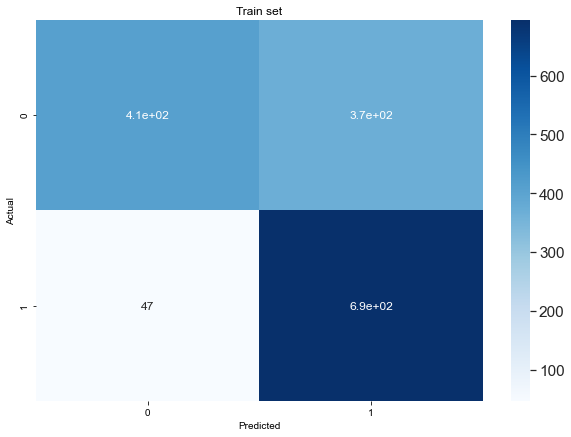

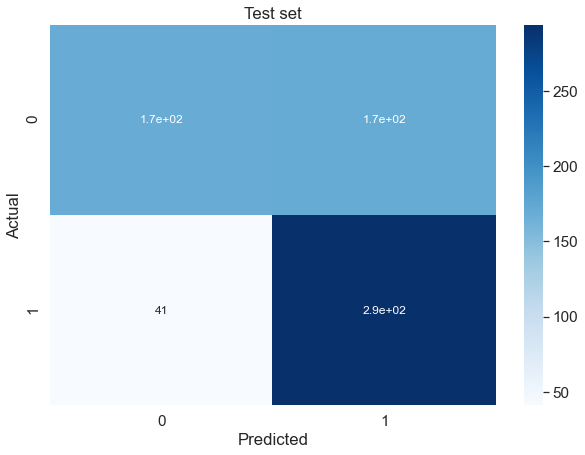

In [13]:
# Plotting GaussianNB results

print(f'Accuracy on Train set is: {acc_train}, Accuracy on Test set is: {acc_test}')
data_gaussianNB_train = confusion_matrix(y_train, p_train_NB)
data_gaussianNB_test  = confusion_matrix(y_test,  p_test_NB)
df_cm = pandas.DataFrame(data_gaussianNB_train, columns=np.unique(y_train), index = np.unique(y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Train set')
seaborn.set(font_scale=1.4)#for label size
seaborn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()
df_cm_test = pandas.DataFrame(data_gaussianNB_test, columns=np.unique(y_test), index = np.unique(y_test))
df_cm_test.index.name = 'Actual'
df_cm_test.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Test set')
seaborn.set(font_scale=1.4)#for label size
seaborn.heatmap(df_cm_test, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()

In [14]:
# DecisionTreeClassifier

# Decision trees are built using a heuristic called recursive partitioning. 
# This approach is also commonly known as "divide and conquer" 
# because it splits the data into subsets, which are then split repeatedly 
# into even smaller subsets, and so on and so forth until the process stops 
# when the algorithm determines the data within the subsets are sufficiently homogenous, 
# or another stopping criterion has been met.

from sklearn.tree import DecisionTreeClassifier

# model creation
model_DecisionTree = DecisionTreeClassifier()

# model fit
model_DecisionTree.fit(a, labels_train)
p_DTC_train = model_DecisionTree.predict(a)
p_DTC_test = model_DecisionTree.predict(b)

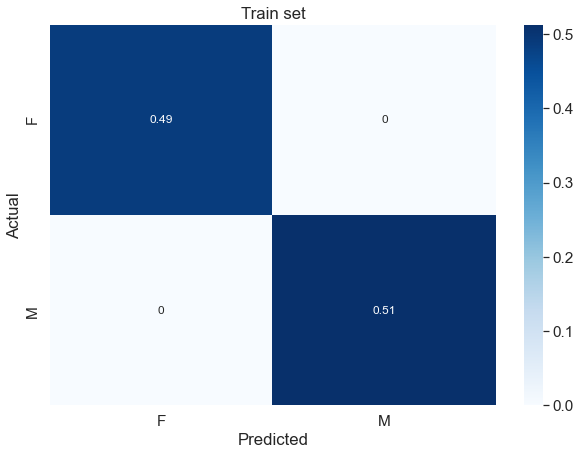

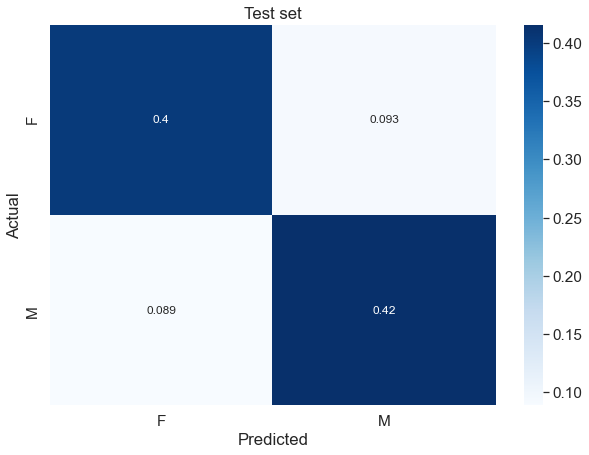

Accuracy on Train: 1.0 
Accuracy on Test:  0.8180473372781065


In [15]:
# Plotting DecisionTreeClassifier results

data_DTC_train = confusion_matrix(labels_train, p_DTC_train, labels=['M','F'], normalize='all')
data_DTC_test  = confusion_matrix(labels_test,  p_DTC_test,  labels=['M','F'], normalize='all')
df_cm = pandas.DataFrame(data_DTC_train, columns=np.unique(labels_train), index = np.unique(labels_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Train set')
seaborn.set(font_scale=1.4)#for label size
seaborn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()
df_cm_test = pandas.DataFrame(data_DTC_test, columns=np.unique(labels_test), index = np.unique(labels_test))
df_cm_test.index.name = 'Actual'
df_cm_test.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Test set')
seaborn.set(font_scale=1.4)#for label size
seaborn.heatmap(df_cm_test, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()
print(f'Accuracy on Train: {df_cm["F"][0]+df_cm["M"][1]} \n'
      f'Accuracy on Test:  {df_cm_test["F"][0]+df_cm_test["M"][1]}' )

In [16]:
# MLP Classifier

# MultiLayer Perceptron is a feedforward artificial neural network model that maps sets of 
# input data onto a set of appropriate outputs. An MLP consists of multiple layers and each 
# layer is fully connected to the following one. The nodes of the layers are neurons using 
# nonlinear activation functions, except for the nodes of the input layer. 
# There can be one or more non-linear hidden layers between the input and the output layer.

from sklearn.neural_network import MLPClassifier

# model creation
model_MLPC = MLPClassifier(hidden_layer_sizes=[10,10])   # output layer self-regulated according to input label
# model fit
model_MLPC.fit(a, y_train)
p_train_MLPC = model_MLPC.predict(a)
p_test_MLPC = model_MLPC.predict(b)
# accuracy
acc_MLPC_train = accuracy_score(y_train, p_train_MLPC)
acc_MLPC_test  = accuracy_score(y_test, p_test_MLPC)

Accuracy on Train set is: 0.9993421052631579, Accuracy on Test set is: 0.7943786982248521


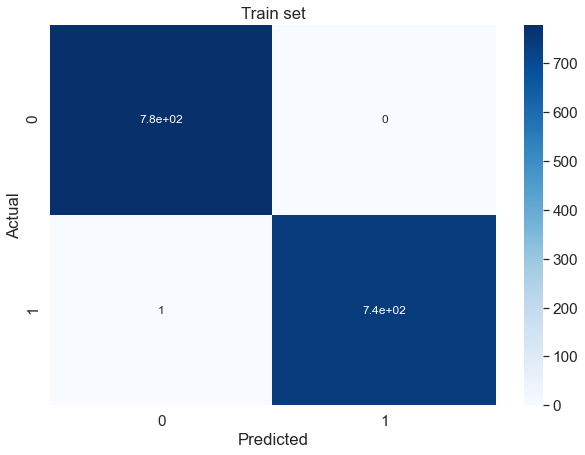

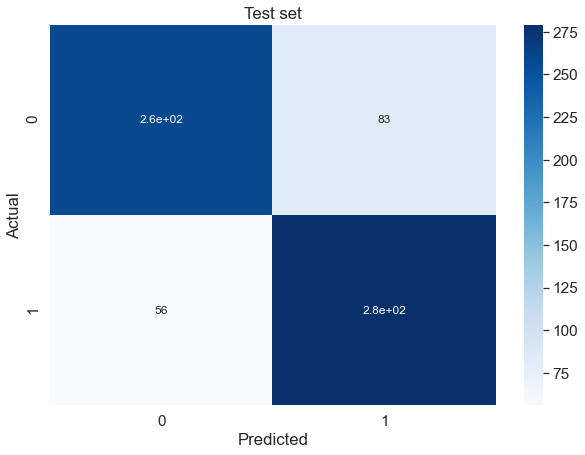

In [17]:
# Plotting MLPC results

print(f'Accuracy on Train set is: {acc_MLPC_train}, Accuracy on Test set is: {acc_MLPC_test}')
data_MLPC_train = confusion_matrix(y_train, p_train_MLPC)
data_MLPC_test  = confusion_matrix(y_test,  p_test_MLPC)
df_cm = pandas.DataFrame(data_MLPC_train, columns=np.unique(y_train), index = np.unique(y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Train set')
seaborn.set(font_scale=1.4)#for label size
seaborn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()
df_cm_test = pandas.DataFrame(data_MLPC_test, columns=np.unique(y_test), index = np.unique(y_test))
df_cm_test.index.name = 'Actual'
df_cm_test.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Test set')
seaborn.set(font_scale=1.4)#for label size
seaborn.heatmap(df_cm_test, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()

In [18]:
# CNN

import tensorflow.keras as keras

# suitable data dimension 
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

In [19]:
# model definition

# build_model based on the architecture of the VGGISH 

def build_model(input_shape):

    model = keras.Sequential()

    #input
    model.add(keras.layers.Conv2D(64,
                                  (3,3),
                                  activation='relu',
                                  padding='same',
                                  input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(4096, activation='relu'))
    model.add(keras.layers.Dense(4096, activation='relu'))

    # output
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [20]:
# useful function for CNN

# prediction function
def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)   # X -> [1,...,...,1]
    predicted_index = np.argmax(prediction, axis=1) # max on the axis 1: [] 1d array
    print(f'Expected index: {y}, Predicted index: {predicted_index}')

# function to plot the history of the fitting
def plot_history(history):
    fig, axs = plt.subplots(2)
    # accuracy
    axs[0].plot(history.history['accuracy'], label='train accuracy')
    axs[0].plot(history.history['val_accuracy'], label='test accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    #axs[0].set_title('Accuracy eval [% error]')
    axs[0].grid(True)
    # error
    axs[1].plot(history.history['loss'], label='train error')
    axs[1].plot(history.history['val_loss'], label='test error')
    axs[1].set_ylabel('Error')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')
    #axs[1].set_title('Error eval')
    axs[1].grid(True)

    plt.show()

In [ ]:
input_shape = (X_train.shape[1], # X_train.shape[0] would be the list
               X_train.shape[2],
               X_train.shape[3])

# model creation
model_CNN = build_model(input_shape)

# compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_CNN.compile(optimizer=optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy']
                  )

# callbacks definition
weights_path = 'D:\\models_weights\\gendre_classification\\model_check_point'
callbacks = [keras.callbacks.EarlyStopping(patience = 10),
             keras.callbacks.ModelCheckpoint(filepath = weights_path,
                                             save_best_only = True,
                                             save_weights_only = True,
                                             monitor = 'val_loss'),
             keras.callbacks.ReduceLROnPlateau(patience=20)
             ]

# train the CNN
history = model_CNN.fit(X_train, y_train,
                        validation_data = (X_val, y_val),
                        batch_size = 32,
                        epochs = 50,
                        callbacks=callbacks)

# Plot History
plot_history(history)

Epoch 1/50
 2/48 [>.............................] - ETA: 24s - loss: 8.0630 - accuracy: 0.7344

In [ ]:
# Evaluation on the test set
model_CNN.load_weights(weights_path)
print('Best weights loaded')
test_error, test_accuracy = model_CNN.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy on the test set is {test_accuracy}')

# Prediction

# Train
true_train = []
predicted_train = []
print('\nPredictions on Training:')
for i in tqdm(range(len(X_train))):
    a = X_train[i]
    b = y_train[i]
    a = a[np.newaxis, ...]
    #true, predicted = predict(model_CNN,a,b)
    predicted = model_CNN.predict(a)
    true_train.append(b)
    predicted_train.append(predicted)
a = np.array(true_train)
b = np.array(predicted_train)
data_train = np.c_[b[:,0,0], a[:,0]] # check data_train

# Validation
true_val = []
predicted_val = []
print('\nPredictions on Validation:')
for i in tqdm(range(len(X_validation))):
    a = X_val[i]
    b = y_val[i]
    true, predicted = predict(model_CNN,a,b)
    true_val.append(true)
    predicted_val.append(predicted)
c = np.array(true_val)
d = np.array(predicted_val)
data_val = np.c_[d[:,0,0], c[:,0]]

# Test
true_test = []
predicted_test = []
print('\nPredictions on Test:')
for i in tqdm(range(len(X_test))):
    a = X_test[i]
    b = y_test[i]
    true, predicted = predict(model_CNN,a,b)
    true_test.append(true)
    predicted_test.append(predicted)
e = np.array(true_test)
f = np.array(predicted_test)
data_test = np.c_[f[:,0,0], e[:,0]]